In [18]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="CiVEpcZNxCfMg4N6pfrs")
project = rf.workspace("brad-dwyer").project("synthetic-fruit")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Synthetic-Fruit-1 in coco:: 100%|██████████| 6004/6004 [00:01<00:00, 4340.88it/s]


In [19]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import os
import numpy as np
import cv2
from pycocotools.coco import COCO

class CustomCocoDataset(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.coco = COCO(annotation)
        self.transforms = transforms
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, index):
        # Get image ID and annotation
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        # Load image
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        img = cv2.imread(os.path.join(self.root, path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = F.to_tensor(img)

        # Prepare bounding boxes and labels
        boxes = []
        labels = []
        for ann in annotations:
            xmin, ymin, width, height = ann['bbox']
            boxes.append([xmin, ymin, xmin + width, ymin + height])
            labels.append(ann['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Target dictionary
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([img_id])

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.ids)


In [ ]:
# Paths to the images and annotations
root_dir = "/content/Synthetic-Fruit-1/train"
annotation_file = "/content/Synthetic-Fruit-1/train/_annotations.coco.json"

# Create the dataset and DataLoader
dataset = CustomCocoDataset(root=root_dir, annotation=annotation_file)
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

In [21]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define the model with the correct number of classes
num_classes = len(dataset.coco.getCatIds()) + 1  # total classes (object classes + background)
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the head of the model with a new one for your dataset's number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Logging
        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {losses.item():.4f}")
        i += 1

print("Training complete!")
torch.save(model.state_dict(), "fasterrcnn_selfo.pth")

Epoch [1/5], Step [1/2500], Loss: 4.7040
Epoch [1/5], Step [11/2500], Loss: 1.0320
Epoch [1/5], Step [21/2500], Loss: 0.5979
Epoch [1/5], Step [31/2500], Loss: 1.2354
Epoch [1/5], Step [41/2500], Loss: 0.3481
Epoch [1/5], Step [51/2500], Loss: 1.3290
Epoch [1/5], Step [61/2500], Loss: 0.5080
Epoch [1/5], Step [71/2500], Loss: 0.6896
Epoch [1/5], Step [81/2500], Loss: 1.3226
Epoch [1/5], Step [91/2500], Loss: 0.7676
Epoch [1/5], Step [101/2500], Loss: 0.8375
Epoch [1/5], Step [111/2500], Loss: 0.3471
Epoch [1/5], Step [121/2500], Loss: 0.9863
Epoch [1/5], Step [131/2500], Loss: 1.4348
Epoch [1/5], Step [141/2500], Loss: 1.0843
Epoch [1/5], Step [151/2500], Loss: 0.6922
Epoch [1/5], Step [161/2500], Loss: 1.1189
Epoch [1/5], Step [171/2500], Loss: 0.2849
Epoch [1/5], Step [181/2500], Loss: 1.3306
Epoch [1/5], Step [191/2500], Loss: 1.1478
Epoch [1/5], Step [201/2500], Loss: 1.2453
Epoch [1/5], Step [211/2500], Loss: 0.3698
Epoch [1/5], Step [221/2500], Loss: 0.9983
Epoch [1/5], Step [231

KeyboardInterrupt: 

In [23]:
torch.save(model.state_dict(), "fasterrcnn_fruit.pth")

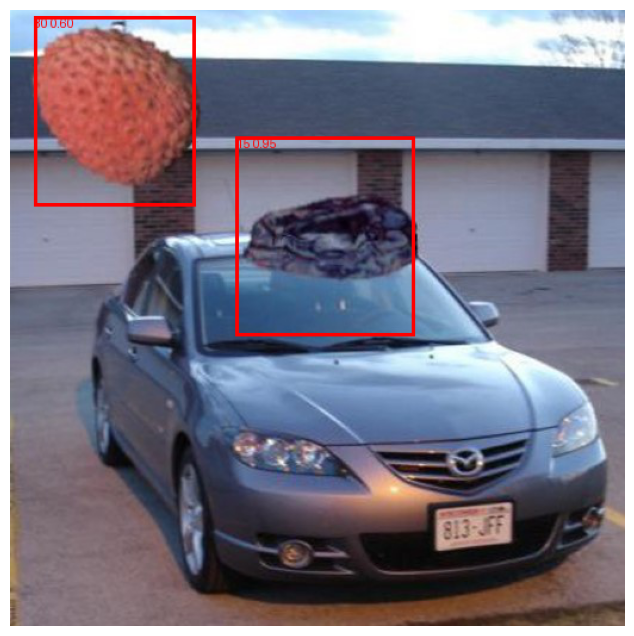

In [8]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load the model and weights
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=65)  # Replace YOUR_NUM_CLASSES
model.load_state_dict(torch.load("fasterrcnn_fruit.pth", map_location=device))
model.to(device)
model.eval()

# Function to draw bounding boxes
def draw_boxes(image, predictions, threshold=0.5):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    
    for idx, box in enumerate(predictions['boxes']):
        score = predictions['scores'][idx].item()
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
            draw.text((xmin, ymin), f"{predictions['labels'][idx].item()} {score:.2f}", fill="red", font=font)
    return image

# Perform inference
image_path = "C:\\Users\\abdul\\Downloads\\fruit.jpg"  # Replace with your test image path
image = Image.open(image_path).convert("RGB")
input_tensor = F.to_tensor(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(input_tensor)
    predictions = outputs[0]

# Draw the bounding boxes
result_image = draw_boxes(image.copy(), predictions, threshold=0.5)

# Display the image with bounding boxes
plt.figure(figsize=(12, 8))
plt.imshow(result_image)
plt.axis("off")
plt.show()
